In [1]:
def my_axis_options(ax):
    ax.loglog()
    ax.set_xlabel("Gate Physical Error Rate × $10^3$ × Helios")
    ax.set_ylabel("Logical Error Rate per round")
    ax.legend()
    ax.grid()
    ax.grid(True, which = 'minor')
    # fig.set_dpi(120)  # Show it bigger
    # ax.set_ylim(1.8e-8, 3.5e-1) # the tham modules paper y lims
    ax.set_ylim(1.3992277047193278e-13, 3.9115107136890295)
    ax.set_xlim(5e-4, 1e-2)
    ax.legend(*zip(*sorted(zip(*ax.get_legend_handles_labels()), key=lambda x: tuple(map(int, re.findall(r'\d+', x[1]))))))  # sort legend labels by number of qubits
    # ax.figure.savefig(f"../plots/tham_modules_noise.png", dpi = 300, bbox_inches = "tight")
    ax.figure.savefig(f"../plots/scrap.png", dpi = 300, bbox_inches = "tight")

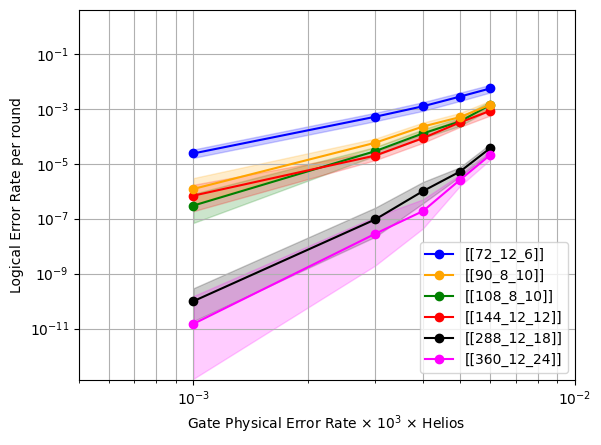

In [2]:
import matplotlib.pyplot as plt
import sinter 
import re

## UPDATE THESE WITH FOLDER NAMES:
# collected_stats = sinter.stats_from_csv_files(f'../collected_stats/collected_stats_tham_modules.csv') #_min_sum_0.625_serial_osd_cs_9.csv')
# collected_stats = sinter.stats_from_csv_files(f'../collected_stats/tham_modules_noise_long_chain_BPOSD_settings.csv', f'../collected_stats/288_12_18_tham_modules_noise_long_chain_BPOSD_settings.csv')
# collected_stats = sinter.stats_from_csv_files("../collected_stats/incl_opp_basis_detectors/collected_stats_tham_modules_incl_opp_detectors.csv", "../collected_stats/incl_opp_basis_detectors/mars_collected_stats_tham_modules_incl_opp_detectors.csv")

## HELIOS:
collected_stats = sinter.stats_from_csv_files(f'../collected_stats/helios_noise/helios_combined.csv', f'../collected_stats/helios_noise/helios_360.csv')



fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['nkd'],
    failure_units_per_shot_func = lambda stats: stats.json_metadata['r'], # set as num_rounds ('r') failure units to find pL per round
    filter_func=lambda s: 
        s.json_metadata['p'] != 2e-3,
        #and s.json_metadata['b'] == 'Z' ,
        # and '288' not in s.json_metadata['nkd'],
    plot_args_func = lambda index, curve_id: {
        'color': 'green' if '108' in curve_id else 'red' if '144' in curve_id else 'orange' if '90' in curve_id else 'blue' if '72' in curve_id else 'black' if '288' in curve_id else 'magenta',
        'marker': 'o'
}

)

my_axis_options(ax)


In [17]:
import sinter

for stat in collected_stats:

    if stat.json_metadata['p'] == 0.001:
        if stat.json_metadata['nkd'] == '[[288_12_18]]':
            print(stat)
    
        


4484127744,         8,         0,39129541.0,bposd,becaafe1053d405ff3a6056be8d3cbc5555009998f303a8b238d871ba22b9e0d,"{""A"":""'300207'"",""B"":""'031020'"",""b"":""X"",""excl_opp_b_detectors"":""True"",""l"":12,""m"":12,""nkd"":""[[288_12_18]]"",""noise"":""helios"",""p"":0.001,""r"":18,""seq_gates"":""True""}",
